In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLasso, GraphicalLassoCV
from scipy import stats
from matplotlib.colors import ListedColormap

import os
from dotenv import load_dotenv
os.chdir("..")

load_dotenv("globs.env")
tickers   = os.getenv("TICKERS").split(",")
media_dir = os.getenv("MEDIA_DIR")
data_dir  = os.getenv("DATA_DIR")

In [ ]:
## Load data
X_df = pd.read_csv(data_dir + "/returns.csv").set_index("date").ffill() # handle NaN
X = StandardScaler().fit_transform(X_df.values)
n, p = X.shape
print(f"n x p:", (n, p))

### Part B

#### Gaussian Graphical Lasso

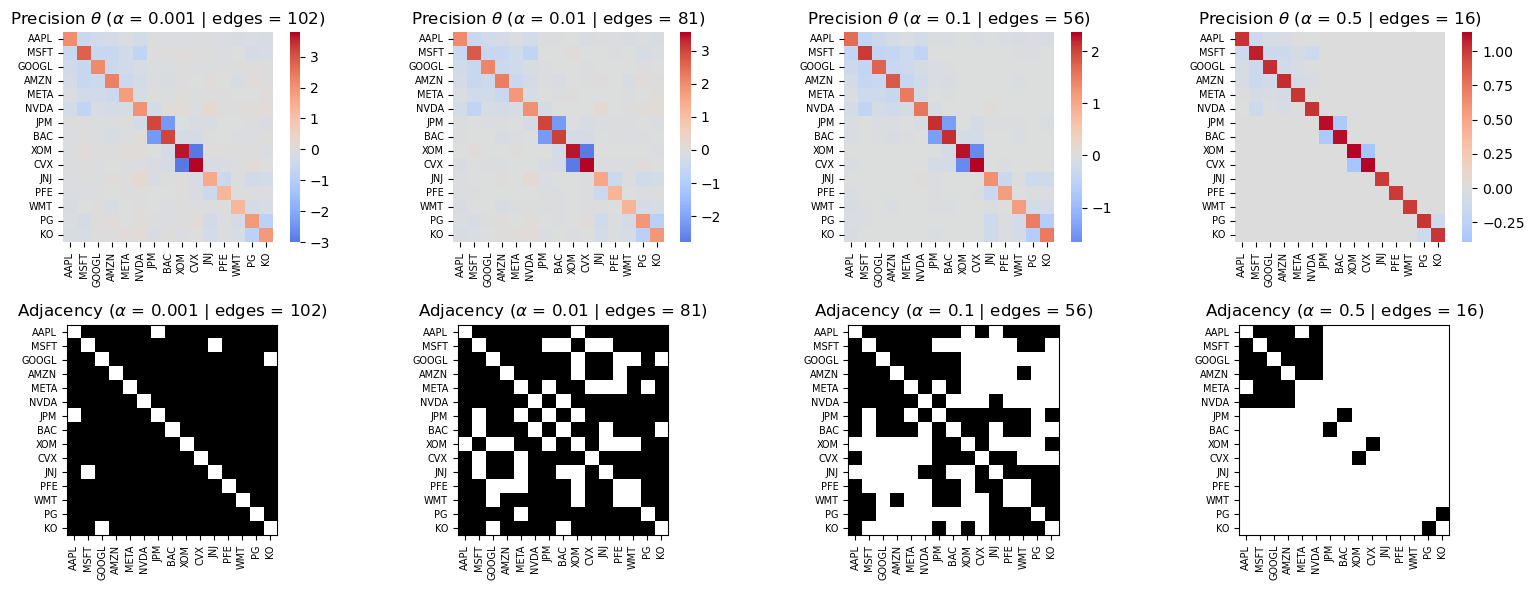

In [ ]:
def run_gl_across_grid():
    alphas = [0.001, 0.01, 0.1, 0.5]
    thetas, adjs, titles = [], [], []

    eps = 1e-6

    for a in alphas:
        gl = GraphicalLasso(alpha=a, max_iter=2000)
        gl.fit(X)
        Theta = gl.precision_

        A = (np.abs(Theta) > eps).astype(int)
        np.fill_diagonal(A, 0)

        thetas.append(Theta)
        adjs.append(A)

        edges = int(np.sum(np.triu(A, 1)))
        titles.append(rf"$\alpha$ = {a:g} | edges = {edges}")

    fig, axes = plt.subplots(2, len(alphas), figsize=(4 * len(alphas), 6))
    cmap_bw = ListedColormap(["white", "black"])

    for i, (Theta, A, ttl) in enumerate(zip(thetas, adjs, titles)):
        # Precision heatmap
        sns.heatmap(
            Theta, center=0, cmap="coolwarm", square=True,
            xticklabels=tickers, yticklabels=tickers,
            cbar_kws={"shrink": 1},
            ax=axes[0, i]
        )
        axes[0, i].set_title(rf"Precision $\theta$ ({ttl})")
        axes[0, i].tick_params(labelsize=7)
        for t in axes[0, i].get_xticklabels(): t.set_rotation(90)

        # adjacency
        axes[1, i].imshow(A, cmap=cmap_bw, vmin=0, vmax=1)
        axes[1, i].set_title(f"Adjacency ({ttl})")
        axes[1, i].set_xticks(range(p)); axes[1, i].set_yticks(range(p))
        axes[1, i].set_xticklabels(tickers, rotation=90, fontsize=7)
        axes[1, i].set_yticklabels(tickers, fontsize=7)

    plt.tight_layout()
    plt.show()

Chosen alpha (CV): 0.0206792


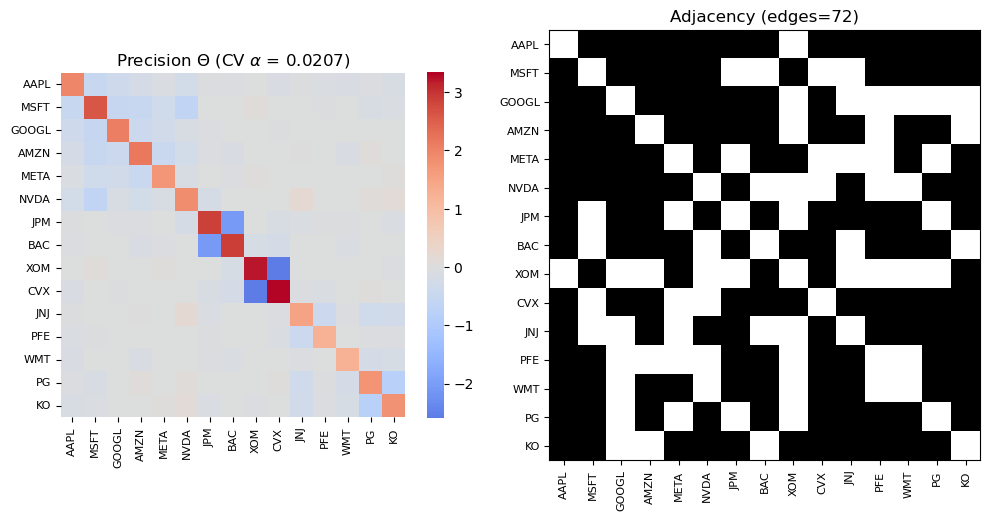

In [49]:
# Fit Graphical Lasso with CV to get alpha_star
glcv = GraphicalLassoCV(alphas=10, cv=5, max_iter=1000).fit(X)
Theta = glcv.precision_
alpha_star = glcv.alpha_
print(f"Chosen alpha (CV): {alpha_star:.6g}")

# Build adjacency from CV precision
eps = 1e-6
A = (np.abs(Theta) > eps).astype(int)
np.fill_diagonal(A, 0)
A = np.maximum(A, A.T)
edges = int(np.sum(np.triu(A, 1)))

# Plot precision + adjacency
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# (A) Precision
sns.heatmap(
    Theta, center=0, cmap="coolwarm", square=True,
    xticklabels=tickers, yticklabels=tickers,
    cbar_kws={"shrink": 0.8},
    ax=axes[0]
)
axes[0].set_title(rf"Precision $\Theta$ (CV $\alpha$ = {alpha_star:.3g})", fontsize=12)
axes[0].tick_params(labelsize=8)
for t in axes[0].get_xticklabels(): t.set_rotation(90)

# (B) Adjacency
axes[1].imshow(A, cmap=ListedColormap(["white", "black"]), vmin=0, vmax=1)
axes[1].set_title(f"Adjacency (edges={edges})", fontsize=12)
axes[1].set_xticks(range(len(tickers)))
axes[1].set_yticks(range(len(tickers)))
axes[1].set_xticklabels(tickers, rotation=90, fontsize=8)
axes[1].set_yticklabels(tickers, fontsize=8)

plt.tight_layout()
plt.show()

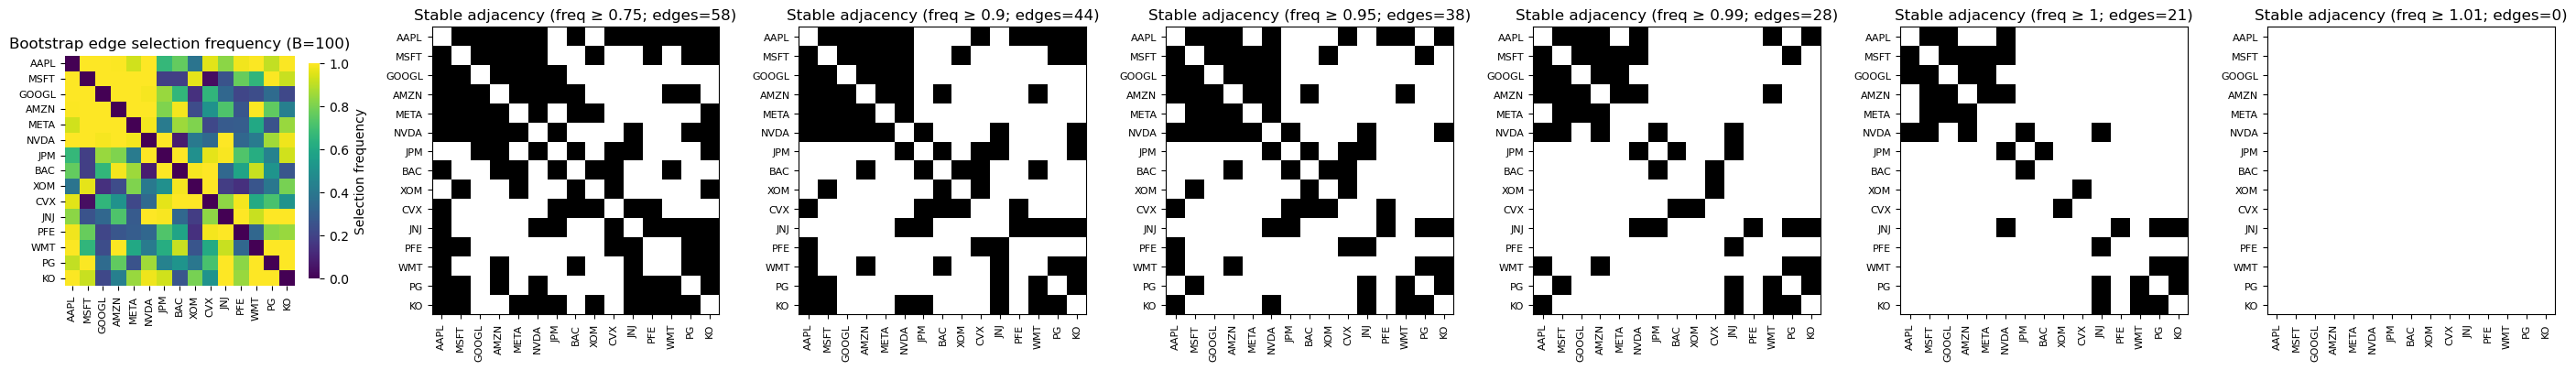

In [ ]:
# Stability Selection with fixed alpha_star
B = 10_000
rng = np.random.RandomState(42)
n, p = X.shape
eps = 1e-8

sel_counts = np.zeros((p, p), dtype=float)

for b in range(B):
    idx = rng.randint(0, n, size=n)
    Xb = X[idx]

    gl = GraphicalLasso(alpha=alpha_star, max_iter=1000, tol=5e-3)
    gl.fit(Xb)
    Theta_b = gl.precision_

    A_b = (np.abs(Theta_b) > eps).astype(int)
    np.fill_diagonal(A_b, 0)
    A_b = np.maximum(A_b, A_b.T)

    sel_counts += A_b

freq = sel_counts / B
np.fill_diagonal(freq, 0.0)

# Threshold frequencies
thr_list = [0.75, 0.90, 0.95, 0.99, 1, 1.01]
m = len(thr_list) + 1
A_thr = []
edge_counts = []

for thr in thr_list:
    A = (freq >= thr).astype(int)
    np.fill_diagonal(A, 0)
    A = np.maximum(A, A.T)
    A_thr.append(A)
    edge_counts.append(int(np.sum(np.triu(A, 1))))

# Plot stability results
fig, axes = plt.subplots(1, m, figsize=(4*m, 5))
cmap_bw = ListedColormap(["white", "black"])

# Plot the selection frequency heatmap
sns.heatmap(
    freq, vmin=0, vmax=1, cmap="viridis", square=True,
    xticklabels=tickers, yticklabels=tickers,
    cbar_kws={"shrink": 0.5, "label": "Selection frequency"},
    ax=axes[0]
)
axes[0].set_title("Bootstrap edge selection frequency (B=100)")
axes[0].tick_params(labelsize=8)
for t in axes[0].get_xticklabels():
    t.set_rotation(90)

for i, (thr, A_mat, ecount) in enumerate(zip(thr_list, A_thr, edge_counts), start=1):
    ax = axes[i]
    ax.imshow(A_mat, cmap=cmap_bw, vmin=0, vmax=1)
    ax.set_title(f"Stable adjacency (freq ≥ {thr}; edges={ecount})")
    ax.set_xticks(range(p))
    ax.set_yticks(range(p))
    ax.set_xticklabels(tickers, rotation=90, fontsize=8)
    ax.set_yticklabels(tickers, fontsize=8)

plt.tight_layout()
plt.show()


In [79]:
precision_df = pd.DataFrame(glcv.precision_, columns=tickers, index=tickers)
print(precision_df.loc["NVDA","JNJ"])
precision_df

0.20636204433680924


,AAPL,MSFT,GOOGL,AMZN,META,NVDA,JPM,BAC,XOM,CVX,JNJ,PFE,WMT,PG,KO
AAPL,1.962618,-0.518594,-0.350959,-0.216832,-0.090828,-0.258781,-0.033181,-0.051221,-0.000000,-0.116573,-0.040605,-0.083702,-0.121066,-0.062914,-0.140650
MSFT,-0.518594,2.600830,-0.535566,-0.506823,-0.329727,-0.628666,-0.000000,-0.000000,0.071282,-0.000000,-0.000000,-0.033138,-0.018524,-0.140785,-0.074967
GOOGL,-0.350959,-0.535566,2.067624,-0.418064,-0.317421,-0.150912,-0.064957,-0.018581,0.000000,-0.020083,-0.000000,-0.000000,-0.000000,0.000000,0.000000
AMZN,-0.216832,-0.506823,-0.418064,2.168720,-0.449175,-0.264002,-0.052093,-0.119392,0.000000,-0.003009,0.022742,-0.000000,-0.118749,0.068746,0.000000
META,-0.090828,-0.329727,-0.317421,-0.449175,1.734943,-0.152433,-0.000000,-0.052367,0.030859,-0.000000,0.000000,-0.000000,-0.009803,0.000000,0.045331
NVDA,-0.258781,-0.628666,-0.150912,-0.264002,-0.152433,1.873465,-0.183498,-0.000000,0.000000,-0.000000,0.206362,0.000000,0.000000,0.053316,0.101208
JPM,-0.033181,-0.000000,-0.064957,-0.052093,-0.000000,-0.183498,2.857960,-2.072111,-0.000000,-0.146391,-0.103941,-0.032038,-0.021552,-0.000000,-0.090595
BAC,-0.051221,-0.000000,-0.018581,-0.119392,-0.052367,-0.000000,-2.072111,2.907486,-0.171242,-0.223361,-0.000000,-0.017637,-0.080003,-0.015485,-0.000000
XOM,-0.000000,0.071282,0.000000,0.000000,0.030859,0.000000,-0.000000,-0.171242,3.207268,-2.589294,-0.000000,-0.000000,-0.000000,0.000000,-0.056348
CVX,-0.116573,-0.000000,-0.020083,-0.003009,-0.000000,-0.000000,-0.146391,-0.223361,-2.589294,3.337812,-0.042521,-0.071657,-0.018936,0.045503,-0.001044


Text(0.5, 1.0, 'Precision $\\Theta$ (CV α = 0.0207)')

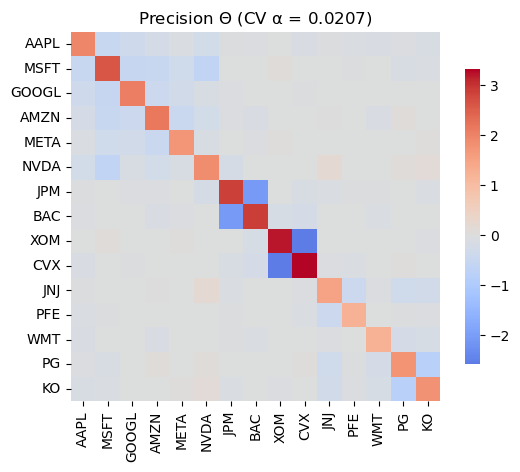

In [80]:
sns.heatmap(
    precision_df, center=0, cmap="coolwarm", square=True,
    xticklabels=tickers, yticklabels=tickers, cbar_kws={"shrink": 0.8}
)
plt.title(rf"Precision $\Theta$ (CV α = {alpha_star:.3g})")


In [ ]:
from sklearn.covariance import GraphicalLasso
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

alphas = [0.001, 0.01, 0.1, 0.5]
B = 100
eps = 1e-8
rng = np.random.RandomState(10001)

stable_results = {}   # will store frequency matrices and stable adjacency for each α

for alpha in alphas:
    sel_counts = np.zeros((p, p), dtype=float)

    for b in range(B):
        idx = rng.randint(0, n, size=n)
        Xb = X[idx]

        gl = GraphicalLasso(alpha=alpha, max_iter=2000, tol=5e-3)
        gl.fit(Xb)
        Theta_b = gl.precision_

        A_b = (np.abs(Theta_b) > eps).astype(int)
        np.fill_diagonal(A_b, 0)
        A_b = np.maximum(A_b, A_b.T)

        sel_counts += A_b

    freq = sel_counts / B
    np.fill_diagonal(freq, 0.0)

    # compute stable adjacencies at different τ
    thr_list = [0.75, 0.90, 0.95, 0.99]
    A_thr = []
    edge_counts = []

    for thr in thr_list:
        A = (freq >= thr).astype(int)
        np.fill_diagonal(A, 0)
        A = np.maximum(A, A.T)
        A_thr.append(A)
        edge_counts.append(int(np.sum(np.triu(A, 1))))

    stable_results[alpha] = {
        "freq": freq,
        "A_thr": A_thr,
        "edge_counts": edge_counts
    }

    print(f"alpha={alpha}: edges @ τ=0.90 = {edge_counts[1]}")
    

In [ ]:
def plot_stability(alpha_star):
    freq = stable_results[alpha_star]["freq"]
    A_thr = stable_results[alpha_star]["A_thr"]
    edge_counts = stable_results[alpha_star]["edge_counts"]

    thr_list = [0.75, 0.90, 0.95, 0.99]
    m = len(thr_list) + 1

    fig, axes = plt.subplots(1, m, figsize=(5*m, 5))
    cmap_bw = ListedColormap(["white", "black"])

    # (A) Stability frequency heatmap
    sns.heatmap(
        freq, vmin=0, vmax=1, cmap="viridis", square=True,
        xticklabels=tickers, yticklabels=tickers,
        cbar_kws={"shrink": 0.6, "label": "Selection frequency"},
        ax=axes[0]
    )
    axes[0].set_title(f"Freq (α={alpha_star}, B={B})", fontsize=12)
    axes[0].tick_params(labelsize=7)
    for t in axes[0].get_xticklabels(): 
        t.set_rotation(90)

    # (B–D) Stable adjacency at τ = 0.75 / 0.90 / 0.95
    for i, (ax, A, thr, e) in enumerate(zip(axes[1:], A_thr, thr_list, edge_counts)):
        ax.imshow(A, cmap=cmap_bw, vmin=0, vmax=1)
        ax.set_title(f"τ ≥ {thr}\nedges={e}", fontsize=12)
        ax.set_xticks(range(p)); ax.set_yticks(range(p))
        ax.set_xticklabels(tickers, rotation=90, fontsize=7)
        ax.set_yticklabels(tickers, fontsize=7)

    plt.tight_layout()
    plt.show()

for alpha_star in alphas: # chosen via stability
    plot_stability(alpha_star)

### work through code

In [ ]:
glcv = GraphicalLassoCV(alphas=10, cv=5, max_iter=2000).fit(X)

Theta = glcv.precision_
alpha_star = glcv.alpha_

eps = 1e-8
A = (np.abs(Theta) > eps).astype(int)
np.fill_diagonal(A, 0)
A = np.maximum(A, A.T)

edges = int(np.sum(np.triu(A, 1)))

print(f"Chosen α (CV): {alpha_star:.6f}")
print("Edges:", edges)


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(
    Theta, center=0, cmap="coolwarm", square=True,
    xticklabels=tickers, yticklabels=tickers,
    cbar_kws={"shrink": 0.8},
    ax=axes[0]
)
axes[0].set_title(rf"Precision $\Theta$ (CV α = {alpha_star:.3g})")
for t in axes[0].get_xticklabels(): t.set_rotation(90)

# adjacency
axes[1].imshow(A, cmap=ListedColormap(["white", "black"]), vmin=0, vmax=1)
axes[1].set_title(f"Adjacency (edges={edges})")

axes[1].set_xticks(range(p)); axes[1].set_yticks(range(p))
axes[1].set_xticklabels(tickers, rotation=90, fontsize=8)
axes[1].set_yticklabels(tickers, fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
def gaussian_copula_transform(X):
    Xn = np.zeros_like(X)
    for j in range(X.shape[1]):
        ranks = stats.rankdata(X[:, j], method="average")
        u = (ranks - 0.5) / len(ranks)
        Xn[:, j] = stats.norm.ppf(u)
    return Xn

X_gc = gaussian_copula_transform(X_df.values)
X_gc = StandardScaler().fit_transform(X_gc)


In [ ]:
gl_gc = GraphicalLassoCV(alphas=10, cv=5, max_iter=2000).fit(X_gc)
Theta_gc = gl_gc.precision_
alpha_star_cop = gl_gc.alpha_

eps = 1e-8
A_gc = (np.abs(Theta_gc) > eps).astype(int)
np.fill_diagonal(A_gc, 0)
A_gc = np.maximum(A_gc, A_gc.T)

edges_gc = int(np.sum(np.triu(A_gc, 1)))

print(f"Chosen α (copula CV): {alpha_star_cop:.6f}")
print("Edges:", edges_gc)


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(
    Theta_gc, center=0, cmap="coolwarm", square=True,
    xticklabels=tickers, yticklabels=tickers,
    cbar_kws={"shrink": 0.8},
    ax=axes[0]
)
axes[0].set_title(rf"Precision $\Theta$ (Copula; CV α = {alpha_star_cop:.3g})")
for t in axes[0].get_xticklabels(): t.set_rotation(90)

axes[1].imshow(A_gc, cmap=ListedColormap(["white", "black"]), vmin=0, vmax=1)
axes[1].set_title(f"Adjacency (edges={edges_gc})")

axes[1].set_xticks(range(p)); axes[1].set_yticks(range(p))
axes[1].set_xticklabels(tickers, rotation=90, fontsize=8)
axes[1].set_yticklabels(tickers, fontsize=8)

plt.tight_layout()
plt.show()
